# Automatic Feature Selection

__Import libraries__

In [21]:
# essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mglearn

# dataset
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer

# preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# ML algorithms
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

- We might be tempted to add more features to get better performance, but adding more features makes all models more complex, and increase the chance of overfitting.
- With high-dimesionality datasets it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest.
- There are three basic strategies of feature selection: univariate statistics, model based selection, and iterative selection.
- All of these methods are supervised.

---

## Univariate Statistics

- We compute whether there is statistically significant relationship between feature to target vector, then features that are related with the highest confidence are selected.
- They are univariate which means they consider it individually, consequently it will be discarded if it is informative when combined with others.
- Fast to compute and don't require building a model. On the other hand, they are completely independent of the model that you might want to apply after the feature selection.
- To use univariate feature selection, we have to choose f_classif (for classification) and f_regression (for regression).
- Method to discard features based on p-values determined in the test.
- All methods for discarding parameters use a threshold to discard all features with too high a p-value (which means they are unlikely to be related to the target).
- The methods differ in how they compute this threshold, with the simplest ones being SelectKB est, which selects a fixed number k of features, and SelectPercentile, which selects a fixed percentage of features.

To make it harder we add noise to the dataset, breast cancer dataset

In [3]:
cancer = load_breast_cancer()

# get deterministic random numbers
# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, 
                                                    random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features.
select = SelectPercentile(percentile=50).fit(X_train, y_train)
# transforming the trainig set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


In [12]:
mask = select.get_support()
print(mask.reshape(1, -1).shape)

(1, 80)


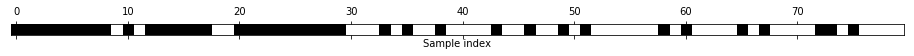

In [10]:
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(());

In [15]:
# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression().fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr = LogisticRegression().fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(lr.score(X_test_selected, y_test)))

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score with all features: 0.930
Score with only selected features: 0.940


C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


- If the dataset is highly dimensional and that building a model is infeasible, we can use feature selection to discard uninformative features.

---

## Model-Based Feature Selection

- Model based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps the important ones.
- The supervised model used for feature selection does not have to be the same as supervised model used for final modeling.
- Decision trees and decision tree–based models provide a feature_importances_, attribute, which directly encodes the importance of each feature.
- Linear models have coefficients, which can also be used to capture feature importances by considering the absolute values.
- In contrast to univariate selection, model-based selection considers all features at once, and so can capture interactions (if the model can capture them).

In [17]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                        threshold='median')

- The SelectFromModel class selects all features that have an importance measure of the feature (as provided by the supervised model) greater than the provided threshold.
- We use threshold='median', because we want to compare it with univariate statistics feature selection (select half).

In [18]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


([], <a list of 0 Text yticklabel objects>)

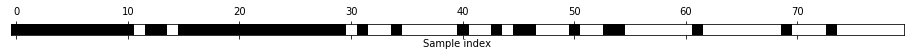

In [19]:
mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [20]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


---

## Iterative Feature Selection

- In univariate feature selection we use no model, in model-based feature selection we use one model.
- In iterative feature selection, a series of models are built, with varying number of features.
- There are two basic methods: starting with no features and adding features one by one until some stopping criterion is reached, or starting with all features and removing features one by one until some stopping criterionis reached.
- Downside: Computationaly expensive.
- One particular method of this kind is recursive feature elimination (RFE), which starts with all features, builds a model, and discards the least important feature according to the model. Then a new model is built using all but the discarded feature, and so on until only a prespecified number of features are left.

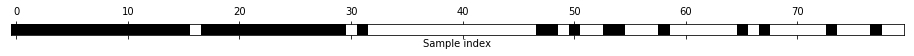

In [25]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
n_features_to_select=40).fit(X_train, y_train)

# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(());

It takes longer because we train random forest 40 times

In [26]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {}".format(score))

Test score: 0.9508771929824561


C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We can also use the model used inside the RFE to make predictions. This uses only
the feature set that was selected:

In [27]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


In most real-world cases, applying feature selection is
unlikely to provide large gains in performance. However, it is still a valuable tool in
the toolbox of the feature engineer.

---

# IMPORTANT POINTS

- We can reduce dimensionality by using feature selection.
- These three methods are supervised methods.
- Univariate Statistics:
    - Compute whether there is statistically significant relationship between features and target.
    - Using p-values to determine it.
    - Feature inspection works individually, so feature that works only when combined will be discarded.
    - Fast, no need to built a model.
    - Choice: f_classif for classification and f_regression for regression.
    - Methods of univariate feature selection:
        - SelectKBest: selecting K important features.
        - SelectPercentile: selecting percentage of all features.
    - SelectPercentile: 
        - Parameter: percentile (0-100)
        - Methods:
            - fit(), ex: select.fit(X_train, y_train)
            - transform(), ex: select.transform(X_train)
            - get_support(): returning masking of features
- Model-Based feature selection:
    - Need model.
    - Use the provided feature importances of each feature.
    - SelectFromModel:
        - Parameters: 
            - Model
            - Threshold
        - Methods:
            - fit()
            - transform()
            - get_support(): returning masking of features
- Iterative Feature Selection:
    - Use a series of model with different number of parameters.
    - Iteratively adding important features or deleting unsignificant features.
    - Downside: Computationaly expensive.
    - Recursive Feature Elimination  (RFE):
        - Parameters:
            - Model
            - n_features_to_select
        - Methods:
            - fit()
            - transform()
            - get_support(): returning masking of features
- We can visualize feature selection we plt.matshow()
- We can use methods and attributes from model inside SelectFromModel or RFE.